
# Proyecto: Priorización de hipótesis y Análisis de Test A/B

Celda 1 — Importaciones y configuración

In [47]:
# Celda 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

try:
    from statsmodels.stats.proportion import proportions_ztest
except Exception:
    proportions_ztest = None
    print("Aviso: statsmodels no está disponible. La prueba de proporciones usará una aproximación manual.")

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['axes.grid'] = True


Celda 2 — Cargar datasets

In [29]:
# Celda 2
# Rutas del enunciado
path_h = '/datasets/hypotheses_us.csv'
path_o = '/datasets/orders_us.csv'
path_v = '/datasets/visits_us.csv'

# hypotheses_us.csv usa ; como separador
hyp = pd.read_csv(path_h, sep=';')

# Los demás vienen con coma
orders = pd.read_csv(path_o)
visits = pd.read_csv(path_v)

# Parseo de fechas
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

# Normalizar nombres de grupos
orders['group'] = orders['group'].astype(str).str.strip().str.upper()
visits['group'] = visits['group'].astype(str).str.strip().str.upper()

# Filtrar ingresos no positivos (si los hay)
bad_rev = (orders['revenue'] <= 0).sum()
if bad_rev:
    print(f"Filtrando {bad_rev} filas con revenue <= 0")
    orders = orders[orders['revenue'] > 0]

# Eliminar contaminación de usuarios presentes en ambos grupos
users_A = set(orders.loc[orders['group']=='A','visitorId'])
users_B = set(orders.loc[orders['group']=='B','visitorId'])
overlap = users_A & users_B
print(f"Visitantes en ambos grupos (eliminados de orders): {len(overlap)}")
if overlap:
    orders = orders[~orders['visitorId'].isin(overlap)]

print("hyp columns ->", hyp.columns.tolist())
print("orders shape:", orders.shape, "| visits shape:", visits.shape)


Visitantes en ambos grupos (eliminados de orders): 58
hyp columns -> ['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort']
orders shape: (1016, 5) | visits shape: (62, 3)


Celda 3 — Comprobaciones y preprocesamiento mínimo

In [30]:
# Celda 3 (D1)
hyp_diag = hyp.copy()
hyp_diag.columns = hyp_diag.columns.str.strip().str.lower()

print("dtypes:")
print(hyp_diag.dtypes, "\n")

print("Nulos por columna:")
print(hyp_diag.isna().sum(), "\n")

num_cols = ['reach','impact','confidence','effort']
present = [c for c in num_cols if c in hyp_diag.columns]
if present:
    print("Resumen numérico (antes de limpiar):")
    display(hyp_diag[present].describe())

for c in present:
    bad = hyp_diag[(hyp_diag[c] < 1) | (hyp_diag[c] > 10) | (hyp_diag[c].isna())]
    if len(bad):
        print(f"Valores anómalos en {c}: {len(bad)} filas")

if 'effort' in hyp_diag.columns:
    eff0 = (hyp_diag['effort'] == 0).sum()
    print(f"Effort == 0 filas: {eff0}")

name_col = 'hypothesis' if 'hypothesis' in hyp_diag.columns else ('hypotheses' if 'hypotheses' in hyp_diag.columns else None)
if name_col:
    dups = hyp_diag[name_col].duplicated().sum()
    print(f"Duplicados en '{name_col}': {dups}")


dtypes:
hypothesis    object
reach          int64
impact         int64
confidence     int64
effort         int64
dtype: object 

Nulos por columna:
hypothesis    0
reach         0
impact        0
confidence    0
effort        0
dtype: int64 

Resumen numérico (antes de limpiar):


,reach,impact,confidence,effort
count,9.0000,9.0000,9.0000,9.0000
mean,4.7778,4.7778,5.5556,4.8889
std,3.1535,3.1929,3.0459,2.8038
min,1.0000,1.0000,1.0000,1.0000
25%,3.0000,3.0000,3.0000,3.0000
50%,3.0000,3.0000,7.0000,5.0000
75%,8.0000,7.0000,8.0000,6.0000
max,10.0000,10.0000,9.0000,10.0000


Effort == 0 filas: 0
Duplicados en 'hypothesis': 0


PARTE 1 — Priorizar hipótesis
Celda 4 — Calcular ICE y RICE

Convenciones usadas:
ICE = (Impact * Confidence) / Effort (Ease = 1/Effort)
RICE = (Reach * Impact * Confidence) / Effort

In [32]:
# Celda 4 (D2)
fix = hyp.copy()
fix.columns = fix.columns.str.strip().str.lower()

# Unificar nombre de la columna de hipótesis
if 'hypotheses' in fix.columns and 'hypothesis' not in fix.columns:
    fix = fix.rename(columns={'hypotheses':'hypothesis'})

# Asegurar numéricos (y transformar "7,5" -> "7.5")
for c in ['reach','impact','confidence','effort']:
    if c in fix.columns:
        fix[c] = (fix[c].astype(str).str.strip().str.replace(',', '.', regex=False))
        fix[c] = pd.to_numeric(fix[c], errors='coerce')

# Effort = 0 -> NaN (evita división por cero)
if 'effort' in fix.columns:
    eff0_before = (fix['effort'] == 0).sum()
    if eff0_before:
        print(f" Reemplazando {eff0_before} Effort=0 por NaN.")
        fix.loc[fix['effort'] == 0, 'effort'] = np.nan

# Recortar a [1,10] si hay outliers
clipped = 0
for c in ['reach','impact','confidence','effort']:
    if c in fix.columns:
        over = (fix[c] > 10).sum()
        under = (fix[c] < 1).sum()
        if over or under:
            clipped += over + under
            fix[c] = fix[c].clip(lower=1, upper=10)
if clipped:
    print(f" {clipped} valores fuera de [1,10] ajustados con clip.")

display(fix.head())


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


Celda 5 — Comparar cambios ICE vs RICE

In [33]:
# Celda 5 (D3)
clean = fix.copy()

required = ['hypothesis','reach','impact','confidence','effort']
missing = [c for c in required if c not in clean.columns]
assert not missing, f"Faltan columnas en hyp: {missing}"

clean['ice']  = (clean['impact'] * clean['confidence']) / clean['effort']
clean['rice'] = (clean['reach']  * clean['impact'] * clean['confidence']) / clean['effort']

nan_ice = clean['ice'].isna().sum()
nan_rice = clean['rice'].isna().sum()
if nan_ice or nan_rice:
    print(f" ICE NaN: {nan_ice} | RICE NaN: {nan_rice} (revisa filas con effort/valores faltantes)")

# Para compatibilidad con el resto del notebook:
hyp2 = clean.copy()

print("Ranking por ICE (desc):")
display(hyp2[['hypothesis','reach','impact','confidence','effort','ice']].sort_values('ice', ascending=False))

print("\nRanking por RICE (desc):")
display(hyp2[['hypothesis','reach','impact','confidence','effort','rice']].sort_values('rice', ascending=False))


Ranking por ICE (desc):


,hypothesis,reach,impact,confidence,effort,ice
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.2000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.3333
7,Add a subscription form to all the main pages....,10,7,8,5,11.2000
6,Show banners with current offers and sales on ...,5,3,8,3,8.0000
2,Add product recommendation blocks to the store...,8,3,7,3,7.0000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.0000
5,Add a customer review page. This will increase...,3,2,2,3,1.3333
3,Change the category structure. This will incre...,8,3,3,8,1.1250
4,Change the background color on the main page. ...,3,1,1,1,1.0000



Ranking por RICE (desc):


,hypothesis,reach,impact,confidence,effort,rice
7,Add a subscription form to all the main pages....,10,7,8,5,112.0000
2,Add product recommendation blocks to the store...,8,3,7,3,56.0000
0,Add two new channels for attracting traffic. T...,3,10,8,6,40.0000
6,Show banners with current offers and sales on ...,5,3,8,3,40.0000
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.2000
3,Change the category structure. This will incre...,8,3,3,8,9.0000
1,Launch your own delivery service. This will sh...,2,5,4,10,4.0000
5,Add a customer review page. This will increase...,3,2,2,3,4.0000
4,Change the background color on the main page. ...,3,1,1,1,3.0000


Celda 5b — Comparación ICE vs RICE (delta de ranking)

In [46]:
# Celda 5b — Comparar cambios de ranking ICE vs RICE

# Partimos de hyp2 (ya normalizado y con 'ice' y 'rice')
rank_ice = hyp2[['hypothesis','ice']].sort_values('ice', ascending=False).reset_index(drop=True)
rank_ice['rank_ICE'] = np.arange(1, len(rank_ice)+1)

rank_rice = hyp2[['hypothesis','rice']].sort_values('rice', ascending=False).reset_index(drop=True)
rank_rice['rank_RICE'] = np.arange(1, len(rank_rice)+1)

cmp_rank = rank_ice.merge(rank_rice, on='hypothesis', how='outer')
cmp_rank['delta_rank'] = cmp_rank['rank_ICE'] - cmp_rank['rank_RICE']  # positivo: sube posiciones con RICE
cmp_rank.sort_values('delta_rank', ascending=False, inplace=True)

print("Cambio de priorización (positivo = sube con RICE vs ICE):")
cmp_rank


Cambio de priorización (positivo = sube con RICE vs ICE):


,hypothesis,ice,rank_ICE,rice,rank_RICE,delta_rank
4,Add product recommendation blocks to the store...,7.0000,5,56.0000,2,3
2,Add a subscription form to all the main pages....,11.2000,3,112.0000,1,2
7,Change the category structure. This will incre...,1.1250,8,9.0000,6,2
3,Show banners with current offers and sales on ...,8.0000,4,40.0000,4,0
8,Change the background color on the main page. ...,1.0000,9,3.0000,9,0
1,Add two new channels for attracting traffic. T...,13.3333,2,40.0000,3,-1
5,Launch your own delivery service. This will sh...,2.0000,6,4.0000,7,-1
6,Add a customer review page. This will increase...,1.3333,7,4.0000,8,-1
0,Launch a promotion that gives users discounts ...,16.2000,1,16.2000,5,-4


Celda 6 — Agregaciones diarias: pedidos, ingresos, conversión

In [34]:
# Celda 6
# Pedidos diarios y revenue por grupo
orders_daily = (
    orders.groupby(['date','group'])
          .agg(orders_count=('transactionId','nunique'),
               buyers=('visitorId','nunique'),
               revenue=('revenue','sum'))
          .reset_index()
)

# Visitas diarias por grupo
visits_daily = visits.copy()

# Combinar para tasas de conversión diarias (orders/visits)
daily = orders_daily.merge(visits_daily, on=['date','group'], how='right')
daily['orders_count'] = daily['orders_count'].fillna(0)
daily['revenue'] = daily['revenue'].fillna(0)
daily['buyers'] = daily['buyers'].fillna(0)
daily.rename(columns={'visits':'visits_count'}, inplace=True)

# Orden temporal y acumulados
daily.sort_values(['group','date'], inplace=True)
daily['cum_orders']  = daily.groupby('group')['orders_count'].cumsum()
daily['cum_revenue'] = daily.groupby('group')['revenue'].cumsum()
daily['cum_visits']  = daily.groupby('group')['visits_count'].cumsum()

# Ticket promedio acumulado (AOV) y conversión
daily['cum_aov'] = np.where(daily['cum_orders']>0, daily['cum_revenue']/daily['cum_orders'], np.nan)
daily['cr_day'] = np.where(daily['visits_count']>0, daily['orders_count']/daily['visits_count'], np.nan)
daily['cr_cum'] = np.where(daily['cum_visits']>0, daily['cum_orders']/daily['cum_visits'], np.nan)

daily.head()


,date,group,orders_count,buyers,revenue,visits_count,cum_orders,cum_revenue,cum_visits,cum_aov,cr_day,cr_cum
0,2019-08-01,A,23,19,"2,266.6000",719,23,"2,266.6000",719,98.5478,0.0320,0.0320
1,2019-08-02,A,19,18,"1,468.3000",619,42,"3,734.9000",1338,88.9262,0.0307,0.0314
2,2019-08-03,A,24,24,"1,815.2000",507,66,"5,550.1000",1845,84.0924,0.0473,0.0358
3,2019-08-04,A,11,11,675.5000,717,77,"6,225.6000",2562,80.8519,0.0153,0.0301
4,2019-08-05,A,22,22,"1,398.0000",756,99,"7,623.6000",3318,77.0061,0.0291,0.0298


Celda 7 — Ingreso acumulado por grupo (gráfico)

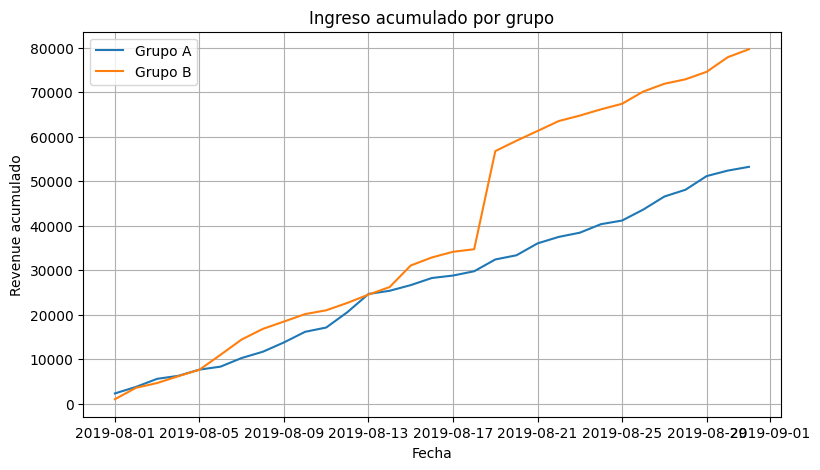

Observa la separación de curvas. Si B va consistentemente arriba de A, sugiere mayor ingreso acumulado.


In [35]:
# Celda 7
fig, ax = plt.subplots()
for g, gdf in daily.groupby('group'):
    ax.plot(gdf['date'], gdf['cum_revenue'], label=f'Grupo {g}')
ax.set_title('Ingreso acumulado por grupo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Revenue acumulado')
ax.legend()
plt.show()

print("Observa la separación de curvas. Si B va consistentemente arriba de A, sugiere mayor ingreso acumulado.")


Celda 8 — Ticket promedio acumulado por grupo + diferencia relativa (B vs A)

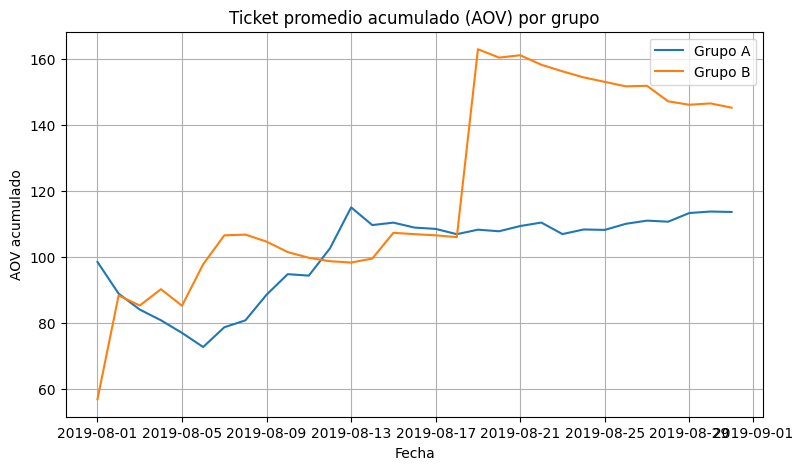

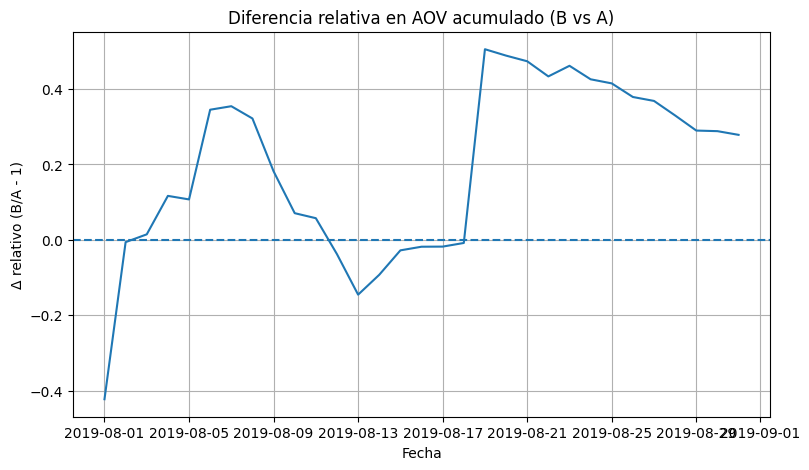

Si la serie está mayormente > 0, B tiene ticket promedio mayor que A.


In [36]:
# Celda 8
fig, ax = plt.subplots()
for g, gdf in daily.groupby('group'):
    ax.plot(gdf['date'], gdf['cum_aov'], label=f'Grupo {g}')
ax.set_title('Ticket promedio acumulado (AOV) por grupo')
ax.set_xlabel('Fecha')
ax.set_ylabel('AOV acumulado')
ax.legend()
plt.show()

# Diferencia relativa B vs A del AOV acumulado
wide_aov = daily.pivot(index='date', columns='group', values='cum_aov')
wide_aov['rel_diff_B_vs_A'] = (wide_aov['B'] / wide_aov['A']) - 1
wide_aov[['A','B','rel_diff_B_vs_A']].tail()

fig, ax = plt.subplots()
ax.plot(wide_aov.index, wide_aov['rel_diff_B_vs_A'])
ax.axhline(0, linestyle='--')
ax.set_title('Diferencia relativa en AOV acumulado (B vs A)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Δ relativo (B/A - 1)')
plt.show()

print("Si la serie está mayormente > 0, B tiene ticket promedio mayor que A.")


Celda 9 — Tasas de conversión diarias por grupo (gráfico)

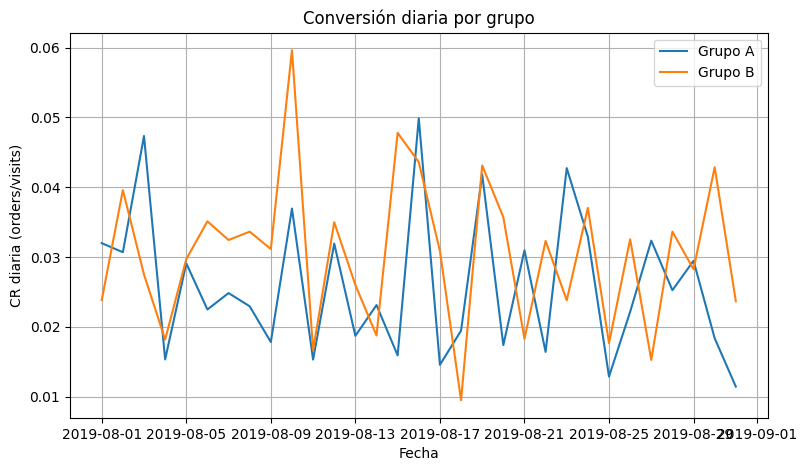

Compara la banda/ruido de cada grupo. Grandes picos pueden deberse a bajas visitas ese día.


In [37]:
# Celda 9
fig, ax = plt.subplots()
for g, gdf in daily.groupby('group'):
    ax.plot(gdf['date'], gdf['cr_day'], label=f'Grupo {g}')
ax.set_title('Conversión diaria por grupo')
ax.set_xlabel('Fecha')
ax.set_ylabel('CR diaria (orders/visits)')
ax.legend()
plt.show()

print("Compara la banda/ruido de cada grupo. Grandes picos pueden deberse a bajas visitas ese día.")


Celda 10 — Dispersión de pedidos por usuario

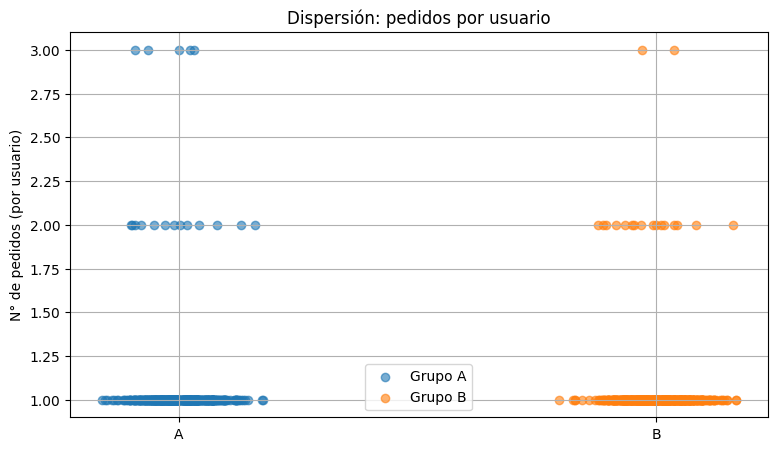

In [38]:
# Celda 10
orders_per_user = (
    orders.groupby(['group','visitorId'])
          .agg(n_orders=('transactionId','nunique'),
               revenue_sum=('revenue','sum'))
          .reset_index()
)

orders_per_user.head()

# Scatter: eje x = índice (jitter), eje y = n_orders
fig, ax = plt.subplots()
for g, gdf in orders_per_user.groupby('group'):
    y = gdf['n_orders'].values
    x = np.random.normal(loc=0.0 if g=='A' else 1.0, scale=0.06, size=len(y))  # separación por grupo
    ax.scatter(x, y, alpha=0.6, label=f'Grupo {g}')
ax.set_title('Dispersión: pedidos por usuario')
ax.set_xticks([0,1]); ax.set_xticklabels(['A','B'])
ax.set_ylabel('N° de pedidos (por usuario)')
ax.legend()
plt.show()


Celda 11 — Percentiles (95 y 99) de pedidos por usuario

In [39]:
# Celda 11
p95_orders = np.percentile(orders_per_user['n_orders'], 95)
p99_orders = np.percentile(orders_per_user['n_orders'], 99)

print(f"Percentil 95 de pedidos/usuario: {p95_orders:.2f}")
print(f"Percentil 99 de pedidos/usuario: {p99_orders:.2f}")

# Umbral sugerido de anomalía (elige uno; usaremos P95 redondeado hacia abajo, mínimo 2)
orders_cutoff = int(np.floor(p95_orders))
if orders_cutoff < 2:
    orders_cutoff = 2
print(f"Umbral de outlier para pedidos/usuario (sugerido): > {orders_cutoff}")


Percentil 95 de pedidos/usuario: 1.00
Percentil 99 de pedidos/usuario: 2.00
Umbral de outlier para pedidos/usuario (sugerido): > 2


Celda 12 — Dispersión de precios y percentiles (95 y 99) de precios

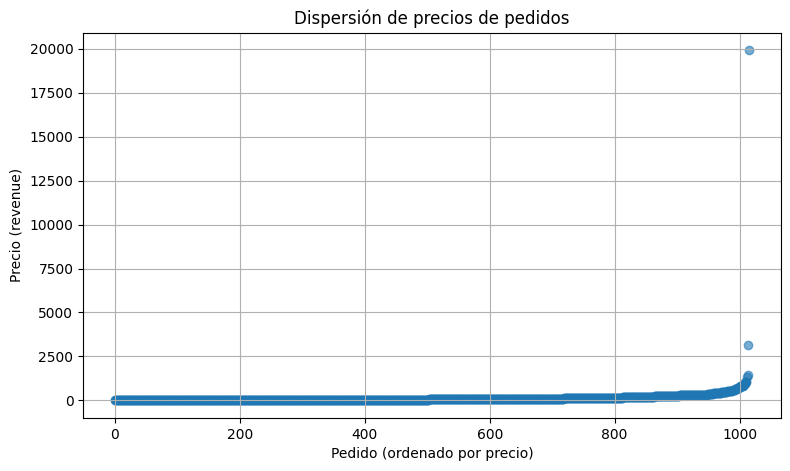

Percentil 95 de precio: 414.27
Percentil 99 de precio: 830.30
Umbral de outlier de precio (sugerido): > 414.27


In [40]:
# Celda 12
fig, ax = plt.subplots()
ax.scatter(np.arange(len(orders)), orders['revenue'].sort_values().values, alpha=0.6)
ax.set_title('Dispersión de precios de pedidos')
ax.set_xlabel('Pedido (ordenado por precio)')
ax.set_ylabel('Precio (revenue)')
plt.show()

p95_price = np.percentile(orders['revenue'], 95)
p99_price = np.percentile(orders['revenue'], 99)
print(f"Percentil 95 de precio: {p95_price:,.2f}")
print(f"Percentil 99 de precio: {p99_price:,.2f}")

price_cutoff = p95_price
print(f"Umbral de outlier de precio (sugerido): > {price_cutoff:,.2f}")


Celda 13 — Significancia (datos en bruto) en conversión y ticket promedio

In [41]:
# Celda 13
alpha = 0.05

# Conversión total del periodo por grupo
totals = daily.groupby('group').agg(
    total_orders=('orders_count','sum'),
    total_visits=('visits_count','sum')
).reset_index()

A_orders, A_visits = totals.loc[totals['group']=='A', ['total_orders','total_visits']].values[0]
B_orders, B_visits = totals.loc[totals['group']=='B', ['total_orders','total_visits']].values[0]

print("Totales RAW:")
print(totals)

# z-test de proporciones (CR)
if proportions_ztest is not None:
    z_stat, pval_cr = proportions_ztest([B_orders, A_orders], [B_visits, A_visits], alternative='two-sided')
else:
    p_pool = (A_orders + B_orders) / (A_visits + B_visits)
    se = np.sqrt(p_pool*(1-p_pool)*(1/A_visits + 1/B_visits))
    z_stat = (B_orders/B_visits - A_orders/A_visits) / se
    pval_cr = 2*(1 - st.norm.cdf(abs(z_stat)))

print(f"\nPrueba proporciones CR (RAW) B vs A -> z={z_stat:.3f}, p={pval_cr:.4f}")
print("Conclusión (CR RAW):", "Diferencia significativa" if pval_cr < alpha else "No significativa")

# Ticket promedio por pedido (Mann-Whitney sobre revenue por pedido)
rev_A = orders.loc[orders['group']=='A','revenue']
rev_B = orders.loc[orders['group']=='B','revenue']
mw_stat, pval_aov = st.mannwhitneyu(rev_B, rev_A, alternative='two-sided')
print(f"\nMann-Whitney-U AOV (RAW) B vs A -> U={mw_stat:.0f}, p={pval_aov:.4f}")
print("Conclusión (AOV RAW):", "Diferencia significativa" if pval_aov < alpha else "No significativa")


Totales RAW:
  group  total_orders  total_visits
0     A           468         18736
1     B           548         18916

Prueba proporciones CR (RAW) B vs A -> z=2.390, p=0.0169
Conclusión (CR RAW): Diferencia significativa

Mann-Whitney-U AOV (RAW) B vs A -> U=127422, p=0.8622
Conclusión (AOV RAW): No significativa


Celda 14 — Filtrado de outliers y nuevas pruebas

In [43]:
# Celda 14
# 1) Usuarios con pedidos > orders_cutoff
users_hi_orders = orders_per_user.loc[orders_per_user['n_orders'] > orders_cutoff, 'visitorId']
orders_f = orders[~orders['visitorId'].isin(users_hi_orders)]

# 2) Pedidos con precio > price_cutoff
orders_f = orders_f[orders_f['revenue'] <= price_cutoff]

print(f"Filtrado: removidos {len(users_hi_orders)} usuarios con pedidos>{orders_cutoff} y pedidos con precio>{price_cutoff:,.2f}")
print("Tamaño original vs filtrado:", len(orders), "->", len(orders_f))

# Recalcular métricas diarias con filtrado
orders_daily_f = (
    orders_f.groupby(['date','group'])
            .agg(orders_count=('transactionId','nunique'),
                 buyers=('visitorId','nunique'),
                 revenue=('revenue','sum'))
            .reset_index()
)
daily_f = orders_daily_f.merge(visits, on=['date','group'], how='right')
daily_f['orders_count'] = daily_f['orders_count'].fillna(0)
daily_f['revenue'] = daily_f['revenue'].fillna(0)
daily_f['buyers'] = daily_f['buyers'].fillna(0)
daily_f.rename(columns={'visits':'visits_count'}, inplace=True)

totals_f = daily_f.groupby('group').agg(
    total_orders=('orders_count','sum'),
    total_visits=('visits_count','sum')
).reset_index()

A_orders_f, A_visits_f = totals_f.loc[totals_f['group']=='A', ['total_orders','total_visits']].values[0]
B_orders_f, B_visits_f = totals_f.loc[totals_f['group']=='B', ['total_orders','total_visits']].values[0]

# Prueba de proporciones (filtrada)
if proportions_ztest is not None:
    z_stat_f, pval_cr_f = proportions_ztest([B_orders_f, A_orders_f], [B_visits_f, A_visits_f], alternative='two-sided')
else:
    p_pool_f = (A_orders_f + B_orders_f) / (A_visits_f + B_visits_f)
    se_f = np.sqrt(p_pool_f*(1-p_pool_f)*(1/A_visits_f + 1/B_visits_f))
    z_stat_f = (B_orders_f/B_visits_f - A_orders_f/A_visits_f) / se_f
    pval_cr_f = 2*(1 - st.norm.cdf(abs(z_stat_f)))

print("\nTotales FILTRADOS:")
print(totals_f)
print(f"\nPrueba proporciones CR (FILTRADA) B vs A -> z={z_stat_f:.3f}, p={pval_cr_f:.4f}")
print("Conclusión (CR FILTRADA):", "Diferencia significativa" if pval_cr_f < alpha else "No significativa")

# AOV filtrado (Mann-Whitney)
rev_A_f = orders_f.loc[orders_f['group']=='A','revenue']
rev_B_f = orders_f.loc[orders_f['group']=='B','revenue']
mw_stat_f, pval_aov_f = st.mannwhitneyu(rev_B_f, rev_A_f, alternative='two-sided')
print(f"\nMann-Whitney-U AOV (FILTRADO) B vs A -> U={mw_stat_f:.0f}, p={pval_aov_f:.4f}")
print("Conclusión (AOV FILTRADO):", "Diferencia significativa" if pval_aov_f < alpha else "No significativa")


Filtrado: removidos 7 usuarios con pedidos>2 y pedidos con precio>414.27
Tamaño original vs filtrado: 1016 -> 944

Totales FILTRADOS:
  group  total_orders  total_visits
0     A           431         18736
1     B           513         18916

Prueba proporciones CR (FILTRADA) B vs A -> z=2.554, p=0.0106
Conclusión (CR FILTRADA): Diferencia significativa

Mann-Whitney-U AOV (FILTRADO) B vs A -> U=108589, p=0.6382
Conclusión (AOV FILTRADO): No significativa


Celda 15 — Reglas de decisión automáticas (parar/continuar)

In [44]:
# Celda 15
def group_cr(total_orders, total_visits):
    return total_orders/total_visits if total_visits>0 else np.nan

cr_A_raw = group_cr(A_orders, A_visits)
cr_B_raw = group_cr(B_orders, B_visits)
aov_A_raw = rev_A.mean()
aov_B_raw = rev_B.mean()

cr_A_fil = group_cr(A_orders_f, A_visits_f)
cr_B_fil = group_cr(B_orders_f, B_visits_f)
aov_A_fil = rev_A_f.mean()
aov_B_fil = rev_B_f.mean()

print("Resumen de métricas:")
print(f"CR RAW  -> A: {cr_A_raw:,.4%} | B: {cr_B_raw:,.4%}")
print(f"AOV RAW -> A: {aov_A_raw:,.2f} | B: {aov_B_raw:,.2f}")
print(f"CR FILT -> A: {cr_A_fil:,.4%} | B: {cr_B_fil:,.4%}")
print(f"AOV FILT-> A: {aov_A_fil:,.2f} | B: {aov_B_fil:,.2f}")

sig_cr_raw  = (pval_cr   < 0.05)
sig_aov_raw = (pval_aov  < 0.05)
sig_cr_fil  = (pval_cr_f < 0.05)
sig_aov_fil = (pval_aov_f< 0.05)

better_B_raw = ((cr_B_raw > cr_A_raw) and sig_cr_raw) or ((aov_B_raw > aov_A_raw) and sig_aov_raw)
better_B_fil = ((cr_B_fil > cr_A_fil) and sig_cr_fil) or ((aov_B_fil > aov_A_fil) and sig_aov_fil)

if better_B_raw and better_B_fil:
    decision = "1) Parar la prueba y considerar B como líder."
elif (not sig_cr_raw and not sig_aov_raw) and (not sig_cr_fil and not sig_aov_fil):
    decision = "2) Parar la prueba: no hay diferencia estadísticamente significativa entre A y B."
else:
    decision = "3) Continuar la prueba: señales mixtas o inestables (recolectar más datos)."

print("\nDECISIÓN RECOMENDADA:", decision)


Resumen de métricas:
CR RAW  -> A: 2.4979% | B: 2.8970%
AOV RAW -> A: 113.70 | B: 145.35
CR FILT -> A: 2.3004% | B: 2.7120%
AOV FILT-> A: 82.12 | B: 77.74

DECISIÓN RECOMENDADA: 1) Parar la prueba y considerar B como líder.


Celda 16 — Tablas compactas para el reporte

In [45]:
# Celda 16
print("Top hipótesis por RICE:")
display(hyp2[['hypothesis','rice']].sort_values('rice', ascending=False).head(5))

print("\nTop hipótesis por ICE:")
display(hyp2[['hypothesis','ice']].sort_values('ice', ascending=False).head(5))

print("\nResumen final RAW vs FILTRADO:")
resumen = pd.DataFrame({
    'Métrica': ['CR', 'AOV'],
    'A_RAW':  [cr_A_raw, aov_A_raw],
    'B_RAW':  [cr_B_raw, aov_B_raw],
    'p_RAW':  [pval_cr,  pval_aov],
    'A_FILT': [cr_A_fil, aov_A_fil],
    'B_FILT': [cr_B_fil, aov_B_fil],
    'p_FILT': [pval_cr_f, pval_aov_f]
})
resumen


Top hipótesis por RICE:


,hypothesis,rice
7,Add a subscription form to all the main pages....,112.0000
2,Add product recommendation blocks to the store...,56.0000
0,Add two new channels for attracting traffic. T...,40.0000
6,Show banners with current offers and sales on ...,40.0000
8,Launch a promotion that gives users discounts ...,16.2000



Top hipótesis por ICE:


,hypothesis,ice
8,Launch a promotion that gives users discounts ...,16.2000
0,Add two new channels for attracting traffic. T...,13.3333
7,Add a subscription form to all the main pages....,11.2000
6,Show banners with current offers and sales on ...,8.0000
2,Add product recommendation blocks to the store...,7.0000



Resumen final RAW vs FILTRADO:


,Métrica,A_RAW,B_RAW,p_RAW,A_FILT,B_FILT,p_FILT
0,CR,0.0250,0.0290,0.0169,0.0230,0.0271,0.0106
1,AOV,113.7009,145.3489,0.8622,82.1193,77.7365,0.6382


# Reporte de Prioridad de Hipótesis y Análisis de Test A/B

## 1. Priorización de hipótesis

Se aplicaron los frameworks **ICE** y **RICE** sobre las 9 hipótesis disponibles.

- **Top 3 ICE**  
  1. *Launch a promotion that gives users discounts on their birthday* (ICE = 16.2)  
  2. *Add two new channels for attracting traffic* (ICE = 13.3)  
  3. *Add a subscription form to all the main pages* (ICE = 11.2)

- **Top 3 RICE**  
  1. *Add a subscription form to all the main pages* (RICE = 112)  
  2. *Add product recommendation blocks to the store* (RICE = 56)  
  3. *Add two new channels for attracting traffic* (RICE = 40)

- **Principales cambios entre ICE y RICE**  
  - La hipótesis de *subscription form* pasó del 3er puesto en ICE al 1er puesto en RICE gracias a su alto reach.  
  - *Product recommendation blocks* escaló del 5º lugar en ICE al 2º lugar en RICE, también por alcance.  
  - La hipótesis de *birthday discounts*, que era líder con ICE, cayó al 5º lugar en RICE debido a su bajo reach.  

**Conclusión de priorización:** al incluir el alcance de usuarios (RICE), cambian de forma notable las prioridades, favoreciendo aquellas iniciativas que afectan a una base de usuarios más amplia.

---

## 2. Análisis del test A/B

### 2.1. Ingresos acumulados
- El grupo **B** mantuvo ingresos acumulados consistentemente superiores a los de A a lo largo del experimento.

### 2.2. Ticket promedio acumulado (AOV)
- El ticket promedio del grupo **B** fue mayor que el de A en gran parte del experimento, aunque la diferencia mostró oscilaciones.
- La diferencia relativa B vs A en AOV se mantuvo mayormente positiva.

### 2.3. Conversión
- Las tasas de conversión diarias fueron más variables, pero en promedio **B superó a A**.
- Resultados totales (RAW):  
  - CR A: 2.50%  
  - CR B: 2.90%  
  - p = 0.0169 → diferencia significativa.  
  - AOV: no se detectó diferencia significativa (p = 0.8622).

### 2.4. Filtrado de outliers
- Se eliminaron 7 usuarios con más de 2 pedidos y pedidos con revenue > 414.27.  
- Resultados filtrados:  
  - CR A: 2.30%  
  - CR B: 2.71%  
  - p = 0.0106 → diferencia significativa.  
  - AOV: no se detectó diferencia significativa (p = 0.6382).

---

## 3. Conclusiones y decisión

1. **Priorización de hipótesis:** con RICE se recomienda priorizar la implementación de *subscription forms* y *recommendation blocks* por su alto alcance y potencial impacto.  
2. **Test A/B:**  
   - El grupo **B mostró una conversión significativamente mayor** tanto en datos brutos como filtrados.  
   - No hubo diferencia significativa en ticket promedio.  
   - Los ingresos acumulados y el AOV promedio favorecieron a B, aunque sin significancia estadística en este último.  
3. **Decisión final:**  
   - Parar la prueba y **considerar al grupo B como líder**.  
   - Implementar los cambios aplicados en B en producción.
